In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

data = pd.read_csv('../adult/adult.data', names=columns, na_values=' ?')

print('Training data shape:', data.shape)

Training data shape: (32561, 15)


In [3]:
data.sample(10)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
29923,55,Local-gov,176046,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,2267,40,United-States,<=50K
30316,22,Private,251196,Some-college,10,Never-married,Protective-serv,Own-child,Black,Female,0,0,20,United-States,<=50K
10831,35,Private,189623,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
10737,55,Private,185436,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,70,United-States,>50K
15239,47,Self-emp-not-inc,228660,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1977,40,United-States,>50K
21669,52,Private,168001,Masters,14,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,>50K
17162,29,Local-gov,132412,Bachelors,13,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,<=50K
32355,45,Self-emp-not-inc,204405,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,20,United-States,<=50K
5476,21,Private,203914,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,10,United-States,<=50K
6458,47,Private,179313,10th,6,Divorced,Sales,Unmarried,White,Female,0,0,30,United-States,<=50K


In [4]:
X = data.drop('income', axis=1)
y = data['income']

In [5]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [6]:
# split into train_val and test sets
train_val_index, test_index = next(skf.split(X, y))
X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]

In [7]:
# split train_val into train and validation sets
inner_skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
train_index, val_index = next(inner_skf.split(X_train_val, y_train_val))
X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

In [8]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (19536, 14)
y_train shape: (19536,)
X_val shape: (6512, 14)
y_val shape: (6512,)
X_test shape: (6513, 14)
y_test shape: (6513,)


In [9]:
# combine train_data and val_data
train_data = X_train.copy()
train_data['income'] = y_train
val_data = X_val.copy()
val_data['income'] = y_val
test_data = X_test.copy()
test_data['income'] = y_test

In [10]:
train_full_data = pd.concat([train_data, val_data], axis=0).reset_index(drop=True)
print('Training data shape:', train_full_data.shape)
print('Test data shape:', test_data.shape)

Training data shape: (26048, 15)
Test data shape: (6513, 15)


In [11]:
# strip whitespaces
string_columns = train_full_data.select_dtypes(include=['object']).columns

for col in string_columns:
    train_full_data[col] = train_full_data[col].str.strip()
    test_data[col] = test_data[col].str.strip()

In [12]:
print('Missing values in the training data:')
print(train_full_data.isnull().sum())

print('Missing values in the test data:')
print(test_data.isnull().sum())

Missing values in the training data:
age                  0
workclass         1451
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1458
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     466
income               0
dtype: int64
Missing values in the test data:
age                 0
workclass         385
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        385
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    117
income              0
dtype: int64


In [18]:
# % of missing values in each column
total_rows = train_full_data.shape[0]
for col in missing_cols:
    missing_percentage = train_full_data[col].isnull().sum() / total_rows * 100
    print(f"{col}: {missing_percentage:.2f}% missing values")

NameError: name 'missing_cols' is not defined

In [19]:
# impute missing values
categorical_cols = train_full_data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')

imputer = SimpleImputer(strategy='most_frequent')

train_full_data[categorical_cols] = imputer.fit_transform(train_full_data[categorical_cols])
# also impute test data
test_data[categorical_cols] = imputer.transform(test_data[categorical_cols])

print('Train data missing values after imputation:')
print(train_full_data.isnull().sum())
print('Test data missing values after imputation:')
print(test_data.isnull().sum())

Train data missing values after imputation:
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64
Test data missing values after imputation:
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


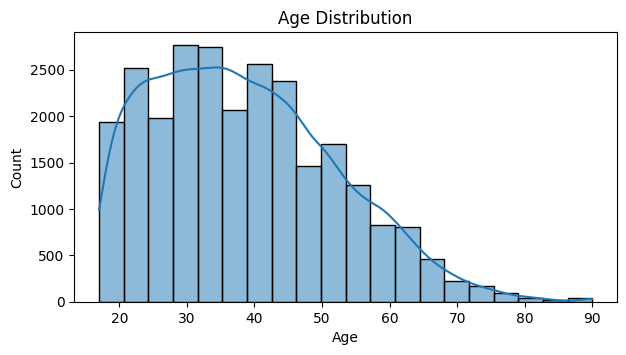

In [20]:
# age distribution
plt.figure(figsize=(7,3.5))
sns.histplot(train_full_data['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='age'>

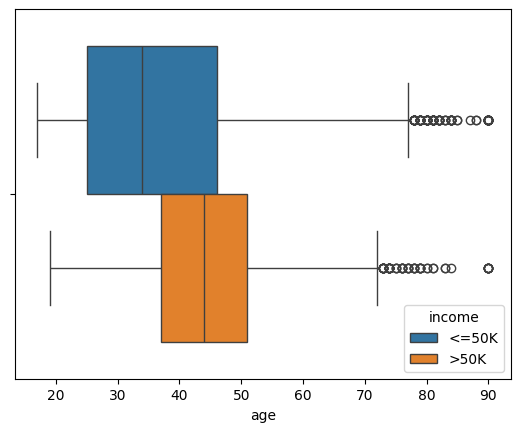

In [21]:
sns.boxplot(x='age', data=train_full_data, hue='income')

In [22]:
# median age
median_age = train_full_data['age'].median()
print('Median age:', median_age)

Median age: 37.0


In [23]:
#Binarize Age
train_full_data['age'] = (train_full_data['age'] >= median_age).astype(int)
test_data['age'] = (test_data['age'] >= median_age).astype(int)

In [24]:
X_train = train_full_data.drop('income', axis=1)
y_train = train_full_data['income']

X_test = test_data.drop('income', axis=1)
y_test = test_data['income']

In [25]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print('Classes:', le.classes_)

Classes: ['<=50K' '>50K']


In [26]:
# Preprocessing Pipeline

# numerical col
numerical_cols = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

# categorical col
categorical_cols = [
    'workclass', 'education', 'marital_status', 'occupation',
    'relationship', 'race', 'sex', 'native_country'
]

# Preprocessing -> numerical
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing -> categorical
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

from sklearn.preprocessing import FunctionTransformer
from scipy.sparse import issparse

# convert sparse matrices to dense (needed for some of the models in testing)
def sparse_to_dense(X):
    return X.toarray() if issparse(X) else X

# Updated preprocessing pipeline (w/ conversion to dense format)
preprocessor = Pipeline(steps=[
    ('columns', ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )),
    ('to_dense', FunctionTransformer(sparse_to_dense))
])

In [27]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = {
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LGBMClassifier(random_state=123))]),
    'XGBoost': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123))]),
    'Gradient Boosting': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GradientBoostingClassifier(random_state=123))]),
    'AdaBoost': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', AdaBoostClassifier(random_state=123))]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=123))]),
    'Extra Trees': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', ExtraTreesClassifier(random_state=123))]),
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))]),
    'Ridge Classifier': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RidgeClassifier())]),
    'LDA': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LinearDiscriminantAnalysis())]),
    'QDA': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', QuadraticDiscriminantAnalysis())]),
    'Naive Bayes': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())]),
    'KNN': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())]),
    'SVM': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC(probability=True, random_state=123))]),
    'Dummy': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DummyClassifier(strategy='most_frequent'))])
}

In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def evaluate_models(models, X, y, cv=5):
    results = []
    from tqdm import tqdm

    # cross validation
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    scoring = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1', 'f1_macro', 'f1_micro', 'f1_weighted']
    
    for name, model in tqdm(models.items(), desc="Model Progress"):
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, n_jobs=-1, return_train_score=False)

        # mean
        mean_accuracy = cv_results['test_accuracy'].mean()
        mean_auc = cv_results['test_roc_auc'].mean()
        mean_precision = cv_results['test_precision'].mean()
        mean_recall = cv_results['test_recall'].mean()
        mean_f1 = cv_results['test_f1'].mean()
        mean_f1_macro = cv_results['test_f1_macro'].mean()
        mean_f1_micro = cv_results['test_f1_micro'].mean()
        mean_f1_weighted = cv_results['test_f1_weighted'].mean()
        
        results.append({
            'Model': name,
            'F1-Weighted': mean_f1_weighted,
            'Accuracy': mean_accuracy,
            'AUC': mean_auc,
            'Recall': mean_recall,
            'Precision': mean_precision,
            'F1-Score': mean_f1,
            'F1-Macro': mean_f1_macro,
            'F1-Micro': mean_f1_micro
        })

    # sort based on F1-Weighted
    return pd.DataFrame(results).sort_values(by='F1-Weighted', ascending=False)

In [29]:
# combine training and validation data
X = X_train
y = y_train

results_cv = evaluate_models(models, X, y, cv=5)

print("Model Evaluation After Binarization:")
print(results_cv)

# save to CSV
# results_cv.to_csv('model_evaluation_after_binarization.csv', index=False)

Model Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [10:10<00:00, 43.63s/it]

Model Evaluation After Binarization:
                  Model  F1-Weighted  Accuracy       AUC    Recall  Precision  \
1               XGBoost     0.860581  0.864942  0.919966  0.636800   0.763207   
0              LightGBM     0.860388  0.865211  0.920410  0.629626   0.768802   
2     Gradient Boosting     0.854703  0.861564  0.914159  0.593116   0.779376   
3              AdaBoost     0.849242  0.855959  0.909230  0.587376   0.759966   
6   Logistic Regression     0.843311  0.849163  0.902750  0.589768   0.731752   
12                  SVM     0.843250  0.851083  0.890977  0.565373   0.754594   
4         Random Forest     0.832070  0.835112  0.878607  0.607783   0.675075   
8                   LDA     0.831298  0.838798  0.888546  0.552141   0.713578   
7      Ridge Classifier     0.824975  0.837109  0.888581  0.495858   0.742102   
11                  KNN     0.824188  0.828164  0.849416  0.581957   0.663086   
5           Extra Trees     0.811448  0.813345  0.837137  0.584026   0.6

In [30]:
# Pipeline with XGBClassifier
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123))
])

In [31]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columns',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['fnlwgt',
                                                                    'education_num',
                                                                    'capital_gain',
                                                                    'capital_loss',
                                                                    'hours_per_week']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    O...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [32]:
# Evaluating on Test Set
y_pred_test = clf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)

print('Test Accuracy:', accuracy_test)
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

Test Accuracy: 0.8673422385997236
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4944
           1       0.78      0.63      0.70      1569

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513



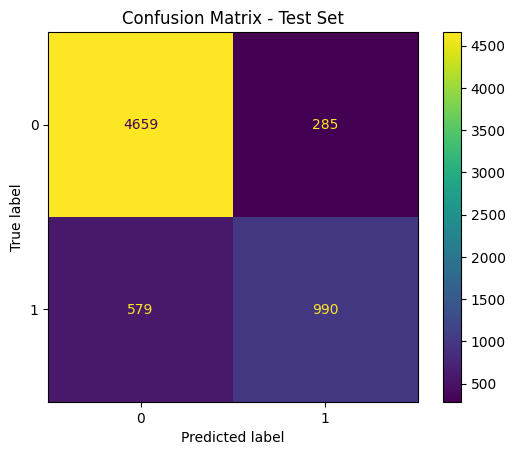

In [33]:
# Confusion matrix for test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot()
plt.title('Confusion Matrix - Test Set')
plt.show()

Test ROC AUC: 0.9223704470309662


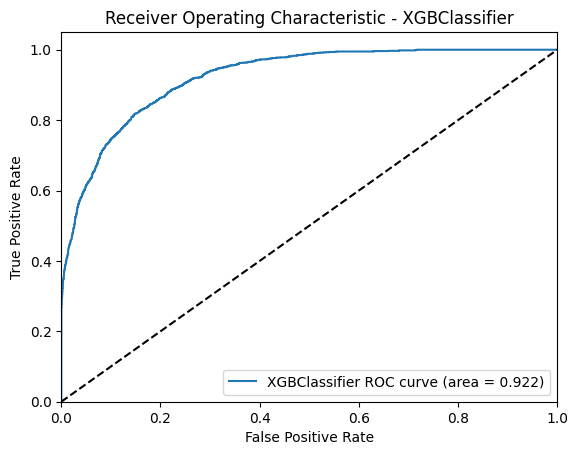

In [35]:
# ROC Curve and AUC for XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

y_scores = clf.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_scores)
print('Test ROC AUC:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0,1],[0,1],'k--')  # Diagonal line
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBClassifier')
plt.legend(loc='lower right')
plt.show()

In [36]:
# Pipeline with LGBM Classifier

clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=123))
])

In [37]:
clf_rf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6272, number of negative: 19776
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 694
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240786 -> initscore=-1.148374
[LightGBM] [Info] Start training from score -1.148374


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('columns',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['fnlwgt',
                                                                    'education_num',
                                                                    'capital_gain',
                                                                    'capital_loss',
                                                                    'hours_per_week']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('onehot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['workclass',
                                                                    'education',
                                                                    'marital_status',
                                                                    'occupation',
                                                                    'relationship',
                                                                    'race',
                                                                    'sex',
                                                                    'native_country'])])),
                                 ('to_dense',
                                  FunctionTransformer(func=<function sparse_to_dense at 0x00000160BA06BA60>))])),
                ('classifier', LGBMClassifier(random_state=123))])

In [38]:
# Evaluating on Test Set
y_pred_test_rf = clf_rf.predict(X_test)

accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

print("Classification Report:")
print('Test Accuracy (RF):', accuracy_test_rf)
print(classification_report(y_test, y_pred_test_rf))

Classification Report:
Test Accuracy (RF): 0.8682634730538922
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4944
           1       0.78      0.63      0.70      1569

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513



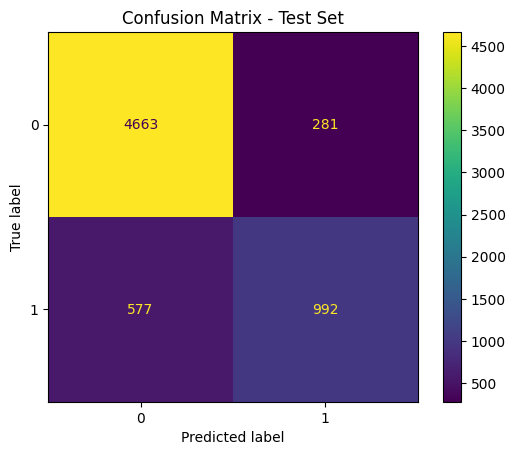

In [39]:
# Confusion matrix for test set
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test_rf)
disp_test.plot()
plt.title('Confusion Matrix - Test Set')
plt.show()

Test ROC AUC (LGBM): 0.9230127588326412


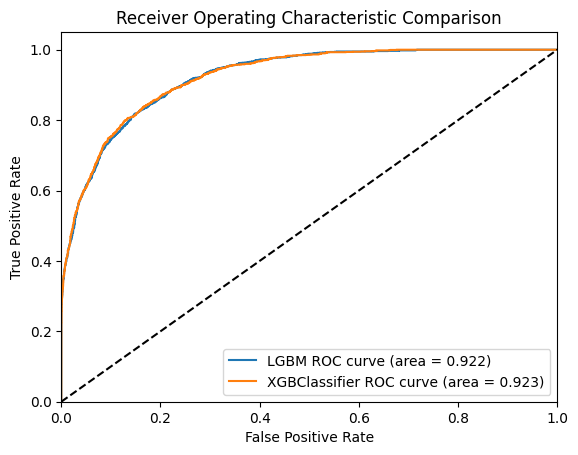

In [40]:
# ROC Curve and AUC for both models
y_scores_rf = clf_rf.predict_proba(X_test)[:,1]
roc_auc_rf = roc_auc_score(y_test, y_scores_rf)
print('Test ROC AUC (LGBM):', roc_auc_rf)

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_scores_rf)
plt.figure()
plt.plot(fpr, tpr, label='LGBM ROC curve (area = %0.3f)' % roc_auc)
plt.plot(fpr_rf, tpr_rf, label='XGBClassifier ROC curve (area = %0.3f)' % roc_auc_rf)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Comparison')
plt.legend(loc='lower right')
plt.show()